In [ ]:
%pip install llama-index-llms-huggingface
%pip install llama-index-llms-huggingface-api
%pip install llama-index
%pip install python-dotenv
%pip install llama-index-llms-gemini
%pip install transformers
%pip install scikit-learn
%pip install matplotlib
%pip install transformers peft datasets
%pip install --upgrade google-cloud-aiplatform

In [1]:
import torch

print("GPU available:", torch.cuda.is_available())

GPU available: True


# PREPROCESSING DATA


In [2]:
from datasets import load_dataset
import pandas as pd

# Load the drugscom_reviews dataset
dataset = load_dataset("Zakia/drugscom_reviews")
df = pd.DataFrame(dataset["train"])
df = df[["review", "rating", "usefulCount"]]
print(df.head(5))

                                              review  rating  usefulCount
0  "It has no side effect, I take it in combinati...     9.0           27
1  "My son is halfway through his fourth week of ...     8.0          192
2  "I used to take another oral contraceptive, wh...     5.0           17
3  "This is my first time using any form of birth...     8.0           10
4  "Suboxone has completely turned my life around...     9.0           37


In [3]:
# Define a function to convert compound sentiment score to Positive/Neutral/Negative label
def score_to_label(rating: float) -> str:
    """Convert compound sentiment score to Positive/Neutral/Negative label."""
    if rating >= 7:
        return "Positive"
    elif rating <= 4:
        return "Negative"
    else:
        return "Neutral"


# Apply the function to the compound_score column to create a new sentiment_label column
df["sentiment_label"] = df["rating"].apply(score_to_label)
print(df.head(5))

                                              review  rating  usefulCount  \
0  "It has no side effect, I take it in combinati...     9.0           27   
1  "My son is halfway through his fourth week of ...     8.0          192   
2  "I used to take another oral contraceptive, wh...     5.0           17   
3  "This is my first time using any form of birth...     8.0           10   
4  "Suboxone has completely turned my life around...     9.0           37   

  sentiment_label  
0        Positive  
1        Positive  
2         Neutral  
3        Positive  
4        Positive  


In [12]:
from sklearn.model_selection import train_test_split

# Define split sizes
TEST_SPLIT_SIZE = 0.10  # 10% for Test set
VALIDATION_SPLIT_SIZE = 0.10  # 10% for Validation set
# Training set will be the remaining 80%

# Calculate intermediate split size (for Val + Test combined)
TEMP_SPLIT_SIZE = TEST_SPLIT_SIZE + VALIDATION_SPLIT_SIZE  # 20%

# Calculate validation size relative to the intermediate set
VAL_RELATIVE_SIZE = VALIDATION_SPLIT_SIZE / TEMP_SPLIT_SIZE  # 0.10 / 0.20 = 0.5

# Ensure we have the columns needed for splitting
if "sentiment_label" not in df.columns or "review" not in df.columns:
    print(
        "Error: DataFrame must contain 'review' and 'sentiment_label' columns before splitting."
    )
    exit()

# Clean data slightly before splitting (remove rows with missing review or label)
df_clean = df.dropna(subset=["review", "sentiment_label"]).copy()
df_clean = df_clean[df_clean["review"].str.strip() != ""]
if len(df_clean) < len(df):
    print(
        f"Removed {len(df) - len(df_clean)} rows with missing review/label before splitting."
    )

# Features (can be just 'review' or more if needed later, but split based on full df for now)
# Target for stratification
y = df_clean["sentiment_label"]

# First split: Separate Train (80%) from Temp (Val + Test) (20%)
print(f"Performing first split (Train/{100*TEMP_SPLIT_SIZE:.0f}% Temp)...")
train_df, temp_df = train_test_split(
    df_clean,
    test_size=TEMP_SPLIT_SIZE,
    random_state=42,  # for reproducibility
    stratify=y,  # Ensure similar sentiment distribution in train and temp
)

# Second split: Separate Validation (10% of original) from Test (10% of original) out of Temp
print(
    f"Performing second split ({100*VAL_RELATIVE_SIZE:.0f}% Val / {100*(1-VAL_RELATIVE_SIZE):.0f}% Test from Temp)..."
)
# Ensure temp_df is not empty
if not temp_df.empty:
    y_temp = temp_df["sentiment_label"]  # Stratify based on temp set labels
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - VAL_RELATIVE_SIZE),  # Test size is 1 - val_relative_size = 0.5
        random_state=42,  # Use same random_state for consistency
        stratify=y_temp,  # Stratify this split as well
    )
else:
    print(
        "Warning: Intermediate temporary DataFrame is empty. Cannot create validation/test sets."
    )
    val_df = pd.DataFrame(columns=df_clean.columns)  # Create empty dataframes
    test_df = pd.DataFrame(columns=df_clean.columns)

# --- Verification ---
print("\n--- Split Verification ---")
print(f"Total original cleaned records: {len(df_clean)}")
print(f"Training set shape:   {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape:       {test_df.shape}")

print("\nTraining set sentiment distribution:")
print(train_df["sentiment_label"].value_counts(normalize=True))
print("\nValidation set sentiment distribution:")
print(val_df["sentiment_label"].value_counts(normalize=True))
print("\nTest set sentiment distribution:")
print(test_df["sentiment_label"].value_counts(normalize=True))
print("-" * 30)

# --- Save the Sets (Optional but Recommended) ---
# It's good practice to save these splits so you don't have to redo it.
train_output_path = "drugscom_train_split.csv"
val_output_path = "drugscom_validation_split.csv"
test_output_path = "drugscom_test_split.csv"  # Use this path for TEST_DATA_PATH later

train_df.to_csv(train_output_path, index=False, encoding="utf-8")
val_df.to_csv(val_output_path, index=False, encoding="utf-8")
test_df.to_csv(test_output_path, index=False, encoding="utf-8")

Performing first split (Train/20% Temp)...
Performing second split (50% Val / 50% Test from Temp)...

--- Split Verification ---
Total original cleaned records: 161297
Training set shape:   (129037, 4)
Validation set shape: (16130, 4)
Test set shape:       (16130, 4)

Training set sentiment distribution:
sentiment_label
Positive    0.662539
Negative    0.248456
Neutral     0.089005
Name: proportion, dtype: float64

Validation set sentiment distribution:
sentiment_label
Positive    0.662554
Negative    0.248419
Neutral     0.089027
Name: proportion, dtype: float64

Test set sentiment distribution:
sentiment_label
Positive    0.662554
Negative    0.248481
Neutral     0.088965
Name: proportion, dtype: float64
------------------------------


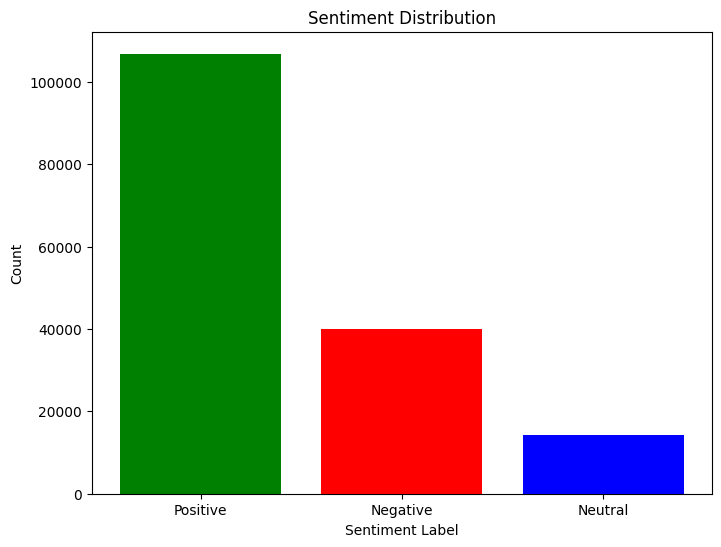

In [4]:
import matplotlib.pyplot as plt

# Count the number of each sentiment label in your dataset
sentiment_counts = df["sentiment_label"].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=["green", "red", "blue"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

In [5]:
import pandas as pd

# 2. Sample 1000 rows per sentiment category
sample_size = 500
sampled_df = (
    df.groupby("sentiment_label", group_keys=False)
    .apply(
        lambda x: x.sample(
            n=sample_size, random_state=42
        )  # random_state for reproducibility
    )
    .reset_index(drop=True)
)

# 3. Verify the counts
print(sampled_df["sentiment_label"].value_counts())
print(sampled_df)
# save to csv
sampled_df.to_csv("drugscom_reviews_sampled.csv", index=False)

sentiment_label
Negative    500
Neutral     500
Positive    500
Name: count, dtype: int64
                                                 review  rating  usefulCount  \
0     "I wouldn&#039;t recommend this to anyone I ha...     1.0            7   
1     "Makes me dizzy, unsteady on feet and sleepy. ...     3.0           24   
2     "I&#039;ve been on Yaz for a year and a half. ...     1.0           14   
3     "I have been using Vagifem 10mcg for 8-9 month...     4.0           70   
4             "Sucked. Didn&#039;t do anything for me."     1.0           13   
...                                                 ...     ...          ...   
1495  "It&#039;s a miracle drug. I took this for anx...    10.0          199   
1496  "I have been on it so a for over six years. I ...    10.0          143   
1497  "I have 5 herniated discs in my neck from bein...     8.0           25   
1498  "This medication was prescribed to me as a 37 ...    10.0            9   
1499  "I have been taking this

C:\Users\super\AppData\Local\Temp\ipykernel_32116\3263169840.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [16]:
import pandas as pd

original_test_path = "drugscom_test_split.csv"
balanced_test_output_path = "drugscom_test_split_BALANCED_500.csv"
sample_size = 500

print(f"Loading original test split: {original_test_path}")
test_df = pd.read_csv(original_test_path)

min_samples = test_df["sentiment_label"].value_counts().min()
if min_samples < sample_size:
    print(f"Warning: Adjusting sample_size from {sample_size} to {min_samples}.")
    sample_size = min_samples

print(f"Creating balanced test set with {sample_size} samples per class...")
balanced_test_df = (
    test_df.groupby("sentiment_label", group_keys=False)
    .apply(lambda x: x.sample(n=sample_size, random_state=42))
    .reset_index(drop=True)
)

print("\nFinal balanced test set distribution:")
print(balanced_test_df["sentiment_label"].value_counts())

balanced_test_df.to_csv(balanced_test_output_path, index=False, encoding="utf-8")
print(f"\nBalanced test data saved to: {balanced_test_output_path}")

Loading original test split: drugscom_test_split.csv
Creating balanced test set with 500 samples per class...

Final balanced test set distribution:
sentiment_label
Negative    500
Neutral     500
Positive    500
Name: count, dtype: int64

Balanced test data saved to: drugscom_test_split_BALANCED_500.csv


C:\Users\super\AppData\Local\Temp\ipykernel_32116\2744378202.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=sample_size, random_state=42))


# TEST CASE


In [3]:
import os
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from llama_index.llms.gemini import Gemini

llm = Gemini(model="models/gemini-2.0-flash")

sample_text = "The doctor was very patient and explained everything clearly. However I have to wait for 2 hours before I can see him which was ridiculous."
response = llm.complete(
    f"""
# Role
You are a Healthcare Sentiment Analysis Specialist with expertise in analyzing medical text data from patient reviews, doctor notes, and clinical conversations.

# Knowledge Base
Your knowledge base consists solely of the resources provided in the **Context** below.
Your task is to analyze patient and doctor sentiment from medical records, reviews, and patient doctor conversations. 
Ensure that all instructions and code are correct and thoroughly documented. Take a deep breath and reason step by step.

# Criteria

Positive: Clear appreciation, relief, or satisfaction (e.g., "The doctor explained everything patiently").

Negative: Frustration, distress, or unresolved issues (e.g., "I waited 6 hours in the ER").

Neutral: Factual statements without emotional tone (e.g., "I visited the clinic on Tuesday").


# Analysis Guidelines

1. Overall Sentiment: 
   - Categorize as Positive/Neutral/Negative
   - Add relevant emoji "Positive": "😊", "Negative": "😡", "Neutral": "🤔"

2. Aspect Breakdown (Include ONLY mentioned aspects):
   - Staff Interactions: If staff/doctors/nurses are referenced
   - Wait Experience: If waiting times/availability are mentioned  
   - Communication: If information exchange/explanation occurs
   - Facility: If physical environment/equipment is discussed
   - Treatment: If medical care/procedures are described

3. For each relevant aspect:
   - 1-2 word sentiment label
   - Brief evidence from text in parentheses
   - Relevant emoji

# Response Format
**Analysis**:
- Overall Sentiment: [label] [emoji]
- Key Aspects: (ONLY include present aspects)
  - [Aspect1]: [sentiment] [emoji] (*[evidence]*)
  - [Aspect2]: [sentiment] [emoji] (*[evidence]*)

# Examples

Example 1 (Multiple Aspects):
Text: "The nurse was rude but the doctor explained my medication clearly."
Analysis:
- Overall Sentiment: Neutral 🤔
- Key Aspects:
  - Staff Interactions: Negative 😡 (*"rude nurse"*)
  - Communication: Positive 😊 (*"explained medication clearly"*)

Example 2 (Single Aspect):
Text: "Waited 3 hours in ER with no updates."
Analysis:
- Overall Sentiment: Negative 😡
- Key Aspects:
  - Wait Experience: Negative 😡 (*"3 hours with no updates"*)

Example 3 (No Specific Aspects):
Text: "Standard checkup experience."
Analysis: 
- Overall Sentiment: Neutral 😐
- Key Aspects: None specifically mentioned

Now analyze this text:
{sample_text}
"""
)
print(response.text)

C:\Users\super\AppData\Local\Temp\ipykernel_35192\1486795477.py:17: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.0-flash")


**Analysis**:
- Overall Sentiment: Neutral 🤔
- Key Aspects:
  - Staff Interactions: Positive 😊 (*"very patient doctor"*)
  - Communication: Positive 😊 (*"explained everything clearly"*)
  - Wait Experience: Negative 😡 (*"wait for 2 hours"*)



# BENCHMARKING LLM (GEMINI FLASH 2.0)


In [8]:
import os
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from llama_index.llms.gemini import Gemini


llm = Gemini(model="models/gemini-2.0-flash")


# Sentiment Analysis Function
def analyze_sentiment(text):
    prompt = f"""
# Role
You are a Healthcare Sentiment Analysis Specialist with expertise in analyzing medical text data from patient reviews, doctor notes, and clinical conversations.

# Knowledge Base
Your knowledge base consists solely of the resources provided in the **Context** below.
Your task is to analyze patient and doctor sentiment from medical records, reviews, and patient doctor conversations. 
Ensure that all instructions and code are correct and thoroughly documented. Take a deep breath and reason step by step.

# Criteria

Positive: Clear appreciation, relief, or satisfaction (e.g., "The doctor explained everything patiently").

Negative: Frustration, distress, or unresolved issues (e.g., "I waited 6 hours in the ER").

Neutral: Factual statements without emotional tone (e.g., "I visited the clinic on Tuesday").


# Analysis Guidelines

1. Overall Sentiment: 
   - Categorize as Positive/Neutral/Negative
   - Add relevant emoji "Positive": "😊", "Negative": "😡", "Neutral": "🤔"

2. Aspect Breakdown (Include ONLY mentioned aspects):
   - Staff Interactions: If staff/doctors/nurses are referenced
   - Wait Experience: If waiting times/availability are mentioned  
   - Communication: If information exchange/explanation occurs
   - Facility: If physical environment/equipment is discussed
   - Treatment: If medical care/procedures are described

3. For each relevant aspect:
   - 1-2 word sentiment label
   - Brief evidence from text in parentheses
   - Relevant emoji

# Response Format
**Analysis**:
- Overall Sentiment: [label] [emoji]
- Key Aspects: (ONLY include present aspects)
  - [Aspect1]: [sentiment] [emoji] (*[evidence]*)
  - [Aspect2]: [sentiment] [emoji] (*[evidence]*)

# Examples

Example 1 (Multiple Aspects):
Text: "The nurse was rude but the doctor explained my medication clearly."
Analysis:
- Overall Sentiment: Neutral 🤔
- Key Aspects:
  - Staff Interactions: Negative 😡 (*"rude nurse"*)
  - Communication: Positive 😊 (*"explained medication clearly"*)

Example 2 (Single Aspect):
Text: "Waited 3 hours in ER with no updates."
Analysis:
- Overall Sentiment: Negative 😡
- Key Aspects:
  - Wait Experience: Negative 😡 (*"3 hours with no updates"*)

Example 3 (No Specific Aspects):
Text: "Standard checkup experience."
Analysis: 
- Overall Sentiment: Neutral 😐
- Key Aspects: None specifically mentioned

Now analyze this text:
{text}
"""
    try:
        response = llm.complete(prompt)

        # Split the response by lines
        lines = response.text.strip().split("\n")

        # Default sentiment (in case we don't find "Overall Sentiment:" line)
        overall_label = "Neutral"

        # Look for a line containing "Overall Sentiment:"
        for line in lines:
            if "Overall Sentiment:" in line:

                parts = line.split(
                    ":", 1
                )  # Split only on the first colon and only takes the 'sentimental part'
                if len(parts) > 1:
                    sentiment_part = parts[1].strip().lower()
                    # sentiment_part might be "positive 😊"
                    if sentiment_part.startswith("positive"):
                        overall_label = "Positive"
                    elif sentiment_part.startswith("negative"):
                        overall_label = "Negative"
                    else:
                        overall_label = "Neutral"
                break

        return overall_label

    except Exception as e:
        print(f"Error processing text: {e}")
        # If an error occurs, default to "Neutral"
        return "Neutral"

In [9]:
# Run Inference with Detailed Tracking
import numpy as np

process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024**2)  # RSS in MB
start_time = time.time()
texts = sampled_df["review"].tolist()
true_labels = sampled_df["sentiment_label"].tolist()
predicted_labels = []
latencies = []

for text in texts:
    sample_start = time.time()

    # Sentiment Analysis
    pred_label = analyze_sentiment(text)
    predicted_labels.append(pred_label)

    # Latency tracking
    sample_latency = time.time() - sample_start
    latencies.append(sample_latency)

total_time = time.time() - start_time
mem_after = process.memory_info().rss / (1024**2)

# Classification Metrics Calculation
# --------------------------------------------------
# Macro averages calculation
accuracy = accuracy_score(true_labels, predicted_labels)
macro_precision = precision_score(true_labels, predicted_labels, average="macro")
macro_recall = recall_score(true_labels, predicted_labels, average="macro")
macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

# Per-class metrics
class_report = classification_report(
    true_labels, predicted_labels, target_names=["Positive", "Neutral", "Negative"]
)

# Confusion Matrix
cm = confusion_matrix(
    true_labels, predicted_labels, labels=["Positive", "Neutral", "Negative"]
)

# Runtime Metrics Calculation
# --------------------------------------------------
# Calculate percentiles for latency
avg_latency = np.mean(latencies)
p95_latency = np.percentile(latencies, 95)
p99_latency = np.percentile(latencies, 99)

throughput = len(texts) / total_time
memory_used = mem_after - mem_before

                   Classification Metrics                   
Accuracy:           0.6573
Precision (Macro):  0.6761
Recall (Macro):     0.6573
F1-Score (Macro):   0.6278

Per-Class Metrics:
              precision    recall  f1-score   support

    Positive       0.56      0.94      0.70       500
     Neutral       0.61      0.27      0.37       500
    Negative       0.86      0.77      0.81       500

    accuracy                           0.66      1500
   macro avg       0.68      0.66      0.63      1500
weighted avg       0.68      0.66      0.63      1500


                    Runtime Performance                     
Total Samples Processed:  1500
Total Inference Time:     1127.13 seconds
Average Latency:          0.7514 sec/sample
95th Percentile Latency:  0.9160 sec
99th Percentile Latency:  1.0190 sec
Throughput:               1.33 samples/sec
Memory Usage (RSS):       2.27 MB


<Figure size 800x600 with 0 Axes>

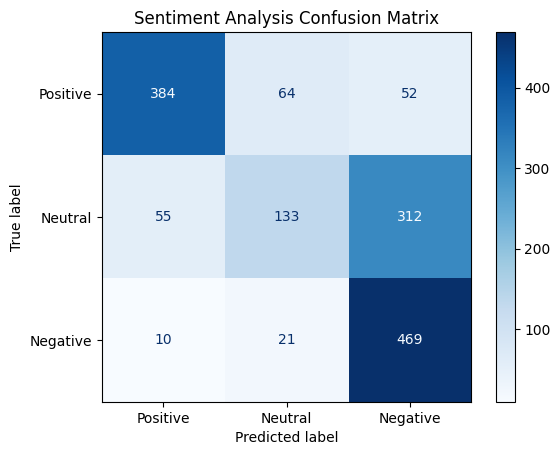

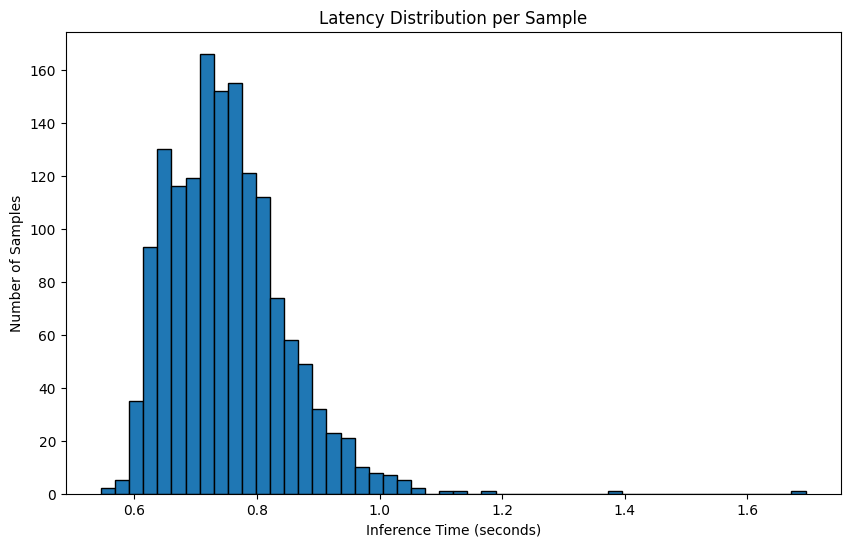

In [10]:
# Benchmark Results Presentation
# --------------------------------------------------
print("=" * 60)
print("Classification Metrics".center(60))
print("=" * 60)
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision (Macro):  {macro_precision:.4f}")
print(f"Recall (Macro):     {macro_recall:.4f}")
print(f"F1-Score (Macro):   {macro_f1:.4f}\n")

print("Per-Class Metrics:")
print(class_report)

print("\n" + "=" * 60)
print("Runtime Performance".center(60))
print("=" * 60)
print(f"Total Samples Processed:  {len(texts)}")
print(f"Total Inference Time:     {total_time:.2f} seconds")
print(f"Average Latency:          {avg_latency:.4f} sec/sample")
print(f"95th Percentile Latency:  {p95_latency:.4f} sec")
print(f"99th Percentile Latency:  {p99_latency:.4f} sec")
print(f"Throughput:               {throughput:.2f} samples/sec")
print(f"Memory Usage (RSS):       {memory_used:.2f} MB")

# Visual Confirmation
# --------------------------------------------------
# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"]
)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Sentiment Analysis Confusion Matrix")
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.show()

# Latency Distribution Plot
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=50, edgecolor="black")
plt.title("Latency Distribution per Sample")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("Number of Samples")
plt.savefig("latency_distribution.png", bbox_inches="tight")
plt.show()

## Overall Evaluation & Recommendations

The model achieves a moderate level of accuracy (~64%) and balanced macro metrics (precision, recall, F1 ~0.60–0.67).

Strengths: Accurately distinguishes Positive and clearly Negative sentiments.

Weaknesses: Tends to over‑label Neutral as Negative, indicating a need for better neutral detection or more nuanced handling of “mildly negative” phrases. (set neutral 4-6 instead of only 5?)

Suggestions:

Data Augmentation: Provide more neutral examples or borderline negative/neutral samples to improve classification boundaries.

Model Fine‑Tuning: Use techniques such as LoRA or adapters (if applicable) to refine performance without fully retraining the entire model.

Post‑Processing Rules: Introduce thresholds or confidence checks to reduce confusion between Neutral and Negative.

Performance Optimization: Investigate outlier latency cases if low latency is mission‑critical; consider batching or model pruning for consistent inference times.


In [ ]:
#########################IGNORE THIS CELL#########################
from textblob import TextBlob


# Using TextBlob for sentiment analysis as a stand-in for Gemini LLM


def classify_sentiment(tweet: str):
    """


    Analyze a tweet's sentiment using an LLM (simulated here with TextBlob).


    Returns a dict with overall emotion, intensity, and aspect-based sentiment breakdown.
    """

    text = tweet.lower()

    analysis = {}

    # Overall sentiment polarity using TextBlob (as a stand-in for Gemini LLM analysis)

    blob = TextBlob(tweet)

    polarity = (
        blob.sentiment.polarity
    )  # range [-1.0, 1.0], where >0 = positive sentiment, <0 = negative

    # Determine overall emotion category

    if polarity > 0.1:

        emotion = "Positive"

    elif polarity < -0.1:

        emotion = "Negative"

    else:

        emotion = "Neutral"

    analysis["emotion"] = emotion

    # Determine intensity of sentiment

    if emotion == "Positive":

        intensity = "Very Positive" if polarity >= 0.6 else "Positive"

    elif emotion == "Negative":

        intensity = "Very Negative" if polarity <= -0.6 else "Negative"

    else:

        intensity = "Neutral"

    analysis["intensity"] = intensity

    # Aspect-based sentiment analysis

    aspect_sentiments = {}

    for aspect, config in aspect_configs.items():

        # Check if any aspect keyword is present in the tweet text

        if any(keyword in text for keyword in config["keywords"]):

            # If aspect context is found, determine sentiment for that aspect

            aspect_sent = "Neutral"  # default sentiment for aspect

            # Check for explicit negative markers first

            for marker in config["negative_markers"]:

                if marker in text:

                    aspect_sent = "Negative"

                    break

            # If no negative sentiment marker was found, check for positive markers

            if aspect_sent == "Neutral":

                for marker in config["positive_markers"]:

                    if marker in text:

                        aspect_sent = "Positive"

                        break

            aspect_sentiments[aspect] = aspect_sent

    analysis["aspects"] = aspect_sentiments

    return analysis

In [ ]:
#########################IGNORE THIS CELL#########################
# Apply the classifier to each tweet and collect predictions

predicted_emotions = []

for tweet in df["tweet"]:

    result = classify_sentiment(tweet)

    predicted_emotions.append(result["emotion"])


# Use scikit-learn to evaluate the model's predictions against reference labels

y_true = df["sentiment_label"].tolist()  # actual labels from the dataset

y_pred = predicted_emotions  # predicted labels from our classifier


accuracy = accuracy_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average="macro")  # macro-averaged F1 for multi-class


print("\nModel Evaluation:")

print("  Accuracy       : {:.2f}%".format(accuracy * 100))

print("  Macro F1-score : {:.2f}%".format(f1 * 100))

print("\nExample Sentiment Analysis on Sample Tweets:\n")


Model Evaluation:
  Accuracy       : 56.07%
  Macro F1-score : 45.51%

Example Sentiment Analysis on Sample Tweets:



In [ ]:
#########################IGNORE THIS CELL#########################
# Prepare to display output with emojis. If no aspect is relevant, we'll show only overall sentiment.

# Define mapping from sentiment label to emoji for convenience

emotion_emoji = {"Positive": "😊", "Negative": "😡", "Neutral": "🤔"}


# Show a few example tweet outputs with sentiment breakdown and emojis

# We'll pick one example from each sentiment category (if available) to demonstrate.

examples = []

for sentiment in ["Positive", "Negative", "Neutral"]:

    # find index of a tweet where the *predicted* emotion matches this sentiment

    try:

        idx = y_pred.index(sentiment)

        examples.append(idx)

    except ValueError:

        continue  # sentiment not present in predictions


# Remove duplicates (in case the first found index overlaps, e.g., if first tweet is positive and index 0 used twice)

examples = sorted(set(examples))

print("Example sentiment analysis on sample tweets:\n")

for idx in examples:

    tweet_text = df.loc[idx, "tweet"]

    result = classify_sentiment(tweet_text)

    overall = result["emotion"]

    intensity = result["intensity"]

    aspects = result["aspects"]

    # Print tweet text with a header

    print("Tweet:")

    print(tweet_text)

    print()  # Blank line for spacing

    # Print overall sentiment and intensity with emojis

    print("Overall Sentiment: {} {}".format(overall, emotion_emoji.get(overall, "")))

    print("Intensity        : {} {}".format(intensity, emotion_emoji.get(overall, "")))

    # Print aspect sentiments (if any)

    if aspects:

        print("Aspect Sentiments:")

        for aspect, sentiment in aspects.items():

            emoji = (
                "✅"
                if sentiment == "Positive"
                else "❌" if sentiment == "Negative" else "🤔"
            )

            print("  - {}: {} {}".format(aspect, sentiment, emoji))

    else:

        print("Aspect Sentiments: (No specific aspects mentioned)")

    # Print a separator line

    print("-" * 50)

Example sentiment analysis on sample tweets:

Tweet:
People with OCD experience intensely negative, repetitive and intrusive thoughts with a chronic feeling of doubt or danger. To calm the anxiety, people with OCD will often repeat an action, these are known as compulsions. If you experience this, therapy can help. #OCDWeek #OCD https://t.co/2MKew1wG4u

Overall Sentiment: Neutral 🤔
Intensity        : Neutral 🤔
Aspect Sentiments:
  - Overall Experience: Negative ❌
--------------------------------------------------
Tweet:
Hello all I'm Erika an @IOCDF grassroots advocate that loves to #rockyourvalues by painting rocks to spread awareness and lower stigma about OCD in our community.  Here is a look back from #OCDweek 2022!! Excited for my workshop at the end of Feb! 🫶

https://t.co/nzsi43m1gW

Overall Sentiment: Positive 😊
Intensity        : Positive 😊
Aspect Sentiments: (No specific aspects mentioned)
--------------------------------------------------
Tweet:
No one should have to convinc

In [ ]:
import pandas as pd
import json
import pandas as pd

# Sample 1000 rows per sentiment category
train_df = 100
sampled_df_2 = (
    df.groupby("sentiment_label", group_keys=False)
    .apply(
        lambda x: x.sample(
            n=train_df, random_state=42
        )  # random_state for reproducibility
    )
    .reset_index(drop=True)
)

# Verify the counts
print(sampled_df_2["sentiment_label"].value_counts())
print(sampled_df_2)
if "sampled_df" not in locals() or sampled_df_2 is None:
    print("Error: sampled_df DataFrame not found. Please load or create it first.")
    # exit() # Or handle loading here

else:
    print("Regenerating data using the 'contents' / 'parts' format...")
    formatted_data_contents = []
    skipped_count = 0

    for index, row in sampled_df_2.iterrows():
        try:
            review_text = str(row["review"]) if pd.notna(row["review"]) else ""
            if not review_text.strip():
                skipped_count += 1
                continue

            # Construct the output dictionary and serialize to JSON string
            output_dict = {
                "rating": int(row["rating"]),
                "sentiment_label": str(row["sentiment_label"]),
            }
            output_json_string = json.dumps(output_dict, sort_keys=True)

            # Create the 'contents' list with user and model parts
            contents_list = [
                {"role": "user", "parts": [{"text": review_text}]},
                {
                    "role": "model",
                    # The model's target output is the JSON string within the 'text' field
                    "parts": [{"text": output_json_string}],
                },
            ]

            # Create the final record for the JSON Line with the top-level "contents" key
            record = {"contents": contents_list}
            formatted_data_contents.append(json.dumps(record))

        except (KeyError, ValueError, TypeError) as e:
            print(f"Warning: Skipping row {index} due to error: {e}")
            skipped_count += 1
            continue

    # Save the new formatted data to a NEW .jsonl file
    output_file_path_contents = (
        "drugscom_rating_sentiment_label_sampled_new.jsonl"  # Use a distinct name
    )
    try:
        with open(output_file_path_contents, "w", encoding="utf-8") as f:
            for line in formatted_data_contents:
                f.write(line + "\n")
        print(
            f"\nRegenerated data in contents format saved to: {output_file_path_contents}"
        )
        print(f"Total valid records written: {len(formatted_data_contents)}")
        if skipped_count > 0:
            print(f"Skipped {skipped_count} rows due to errors or empty reviews.")
    except IOError as e:
        print(f"Error writing new file: {e}")

sentiment_label
Negative    100
Neutral     100
Positive    100
Name: count, dtype: int64
                                                review  rating  usefulCount  \
0    "I wouldn&#039;t recommend this to anyone I ha...     1.0            7   
1    "Makes me dizzy, unsteady on feet and sleepy. ...     3.0           24   
2    "I&#039;ve been on Yaz for a year and a half. ...     1.0           14   
3    "I have been using Vagifem 10mcg for 8-9 month...     4.0           70   
4            "Sucked. Didn&#039;t do anything for me."     1.0           13   
..                                                 ...     ...          ...   
295  "I was on Cymbalta for 2 years and found it to...    10.0           52   
296  "Com purely ashamed to have tested positive fo...     9.0            5   
297  "I just started my second pack of microgestin ...     8.0            9   
298  "Was on Metformin 1000 / 2x day and 70 insulin...     8.0           63   
299  "I started taking Sprintec at 15, an

C:\Users\super\AppData\Local\Temp\ipykernel_32116\2759839792.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [ ]:
import time
import vertexai
from vertexai.tuning import sft  # Supervised Fine-Tuning module
from vertexai.generative_models import GenerativeModel


PROJECT_ID = "gen-lang-client-0989283784"
LOCATION = "us-central1"
SOURCE_MODEL = "gemini-2.0-flash-001"
BUCKET_NAME = "my-unique-llm-datasets"
TRAIN_DATASET_URI = (
    "gs://my-unique-llm-datasets/drugscom_rating_sentiment_label_sampled_new.jsonl"
)
TUNED_MODEL_DISPLAY_NAME = (
    "gemini-flash-drug-reviews-sft-v1"  # (*) Choose a descriptive name
)
EPOCHS = 10

print(f"Initializing Vertex AI SDK for project {PROJECT_ID} in {LOCATION}...")
vertexai.init(project=PROJECT_ID, location=LOCATION)

print(f"\nStarting Supervised Fine-Tuning job...")
print(f"  Base Model: {SOURCE_MODEL}")
print(f"  Training Data: {TRAIN_DATASET_URI}")

# Construct a dictionary for optional arguments to pass to sft.train
sft_train_kwargs = {}
if "VALIDATION_DATASET_URI" in locals() and VALIDATION_DATASET_URI:
    # Check documentation for the exact parameter name (e.g., 'validation_dataset')
    sft_train_kwargs["validation_dataset"] = VALIDATION_DATASET_URI
    print(f"  Validation Data: {VALIDATION_DATASET_URI}")
if "TUNED_MODEL_DISPLAY_NAME" in locals() and TUNED_MODEL_DISPLAY_NAME:
    sft_train_kwargs["tuned_model_display_name"] = TUNED_MODEL_DISPLAY_NAME
    print(f"  Tuned Model Name: {TUNED_MODEL_DISPLAY_NAME}")
if "EPOCHS" in locals():
    # Check documentation for the exact parameter name (e.g., 'epochs')
    sft_train_kwargs["epochs"] = EPOCHS
    print(f"  Epochs: {EPOCHS}")
try:
    sft_tuning_job = sft.train(
        source_model=SOURCE_MODEL,
        train_dataset=TRAIN_DATASET_URI,
        # Pass optional arguments defined above using **kwargs
        **sft_train_kwargs,
    )

    job_resource_name = sft_tuning_job.resource_name  # Store resource name
    print(f"\nSubmitted Tuning Job: {job_resource_name}")
    print(
        f"You can monitor the job in the Google Cloud Console (Vertex AI > Training > Tuning jobs)."
    )

    print("Polling job status every 60 seconds (this can take time)...")
    while not sft_tuning_job.has_ended:
        time.sleep(60)
        sft_tuning_job.refresh()  # Updates the job status from the API

    print("\nTuning Job Ended.")
    print(f"  Final State: {sft_tuning_job.state}")
    # Refresh one last time to ensure final state is captured
    sft_tuning_job.refresh()

    if sft_tuning_job.state == vertexai.JobState.JOB_STATE_SUCCEEDED:
        print(f"  Tuned Model Name (Resource): {sft_tuning_job.tuned_model_name}")
        print(f"  Tuned Model Endpoint: {sft_tuning_job.tuned_model_endpoint_name}")
        # print(f"  Experiment: {sft_tuning_job.experiment}") # May require specific setup/permissions
        print(
            "\nTo use the model, deploy it to an endpoint if not automatically deployed,"
        )
        print("or use the endpoint name above if an endpoint was created.")
    else:
        print(f"  Job did not succeed. Final state: {sft_tuning_job.state}")
        # You might want to fetch error details if available via sft_tuning_job.error (check API reference)


except Exception as e:
    print(f"\nERROR starting or monitoring tuning job: {e}")
    print(
        "Please check configuration, dataset URI, model ID, permissions, and API documentation for 'vertexai.tuning.sft.train'."
    )

Initializing Vertex AI SDK for project gen-lang-client-0989283784 in us-central1...

Starting Supervised Fine-Tuning job...
  Base Model: gemini-2.0-flash-001
  Training Data: gs://my-unique-llm-datasets/drugscom_rating_sentiment_label_sampled_new.jsonl
  Tuned Model Name: gemini-flash-drug-reviews-sft-v1
  Epochs: 10
Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/699359932185/locations/us-central1/tuningJobs/6555457391893151744
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/699359932185/locations/us-central1/tuningJobs/6555457391893151744')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/6555457391893151744?project=699359932185



Submitted Tuning Job: projects/699359932185/locations/us-central1/tuningJobs/6555457391893151744
You can monitor the job in the Google Cloud Console (Vertex AI > Training > Tuning jobs).
Polling job status every 60 seconds (this can take time)...



Tuning Job Ended.
  Final State: 4

ERROR starting or monitoring tuning job: module 'vertexai' has no attribute 'JobState'
Please check configuration, dataset URI, model ID, permissions, and API documentation for 'vertexai.tuning.sft.train'.


# BENCHMARKING LLM AFTER TUNING(GEMINI FLASH 2.0)


In [ ]:
import os
import time
import psutil  # Optional: for resource monitoring
import pandas as pd
import matplotlib.pyplot as plt
import json  # For parsing the model's expected output string

# Scikit-learn metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Vertex AI SDK
import vertexai
from vertexai.generative_models import GenerativeModel


# --- Google Cloud Details ---
PROJECT_ID = "gen-lang-client-0989283784"
LOCATION = "us-central1"
TUNED_MODEL_ENDPOINT_NAME = "projects/gen-lang-client-0989283784/locations/us-central1/endpoints/8217913733230362624"
TEST_DATA_PATH = "drugscom_test_split_BALANCED_500.csv"
REVIEW_COLUMN_NAME = "review"
TRUE_SENTIMENT_COLUMN_NAME = "sentiment_label"
EXPECTED_LABELS = ["Positive", "Negative", "Neutral"]

print(f"Initializing Vertex AI SDK for project {PROJECT_ID} in {LOCATION}...")
try:
    vertexai.init(project=PROJECT_ID, location=LOCATION)
    print("SDK Initialized.")
except Exception as e:
    print(f"Error initializing Vertex AI SDK: {e}")
    exit()

print(f"Loading fine-tuned model from endpoint: {TUNED_MODEL_ENDPOINT_NAME}")
if not TUNED_MODEL_ENDPOINT_NAME or "PASTE_YOUR" in TUNED_MODEL_ENDPOINT_NAME:
    print("Error: TUNED_MODEL_ENDPOINT_NAME is not correctly set in the script.")
    exit()

try:
    # Use the GenerativeModel class with the full endpoint resource name
    tuned_model = GenerativeModel(TUNED_MODEL_ENDPOINT_NAME)
    print("Fine-tuned model loaded successfully.")
except Exception as e:
    print(
        f"Error loading fine-tuned model via endpoint '{TUNED_MODEL_ENDPOINT_NAME}': {e}"
    )
    print(
        "Please ensure the endpoint name is correct and the endpoint is active/deployed in Vertex AI."
    )
    exit()  # Exit if model loading fails

Initializing Vertex AI SDK for project gen-lang-client-0989283784 in us-central1...
SDK Initialized.
Loading fine-tuned model from endpoint: projects/gen-lang-client-0989283784/locations/us-central1/endpoints/8217913733230362624
Fine-tuned model loaded successfully.


In [ ]:
import random
from google.api_core.exceptions import ResourceExhausted


def analyze_sentiment_tuned(text):
    """

    Sends text to the fine-tuned model and parses the expected JSON string output

    to extract the overall sentiment label.
    """

    prompt = f"""

# Role
You are a Healthcare Sentiment Analysis Specialist with expertise in analyzing medical text data from patient reviews, doctor notes, and clinical conversations.

# Knowledge Base
Your knowledge base consists solely of the resources provided in the **Context** below.
Your task is to analyze patient and doctor sentiment from medical records, reviews, and patient doctor conversations. 
Ensure that all instructions and code are correct and thoroughly documented. Take a deep breath and reason step by step.

# Criteria

Positive: Clear appreciation, relief, or satisfaction (e.g., "The doctor explained everything patiently").

Negative: Frustration, distress, or unresolved issues (e.g., "I waited 6 hours in the ER").

Neutral: Factual statements without emotional tone (e.g., "I visited the clinic on Tuesday").


# Analysis Guidelines

1. Overall Sentiment: 
   - Categorize as Positive/Neutral/Negative
   - Add relevant emoji "Positive": "😊", "Negative": "😡", "Neutral": "🤔"

2. Aspect Breakdown (Include ONLY mentioned aspects):
   - Staff Interactions: If staff/doctors/nurses are referenced
   - Wait Experience: If waiting times/availability are mentioned  
   - Communication: If information exchange/explanation occurs
   - Facility: If physical environment/equipment is discussed
   - Treatment: If medical care/procedures are described

3. For each relevant aspect:
   - 1-2 word sentiment label
   - Brief evidence from text in parentheses
   - Relevant emoji

# Response Format
**Analysis**:
- Overall Sentiment: [label] [emoji]
- Key Aspects: (ONLY include present aspects)
  - [Aspect1]: [sentiment] [emoji] (*[evidence]*)
  - [Aspect2]: [sentiment] [emoji] (*[evidence]*)

# Examples

Example 1 (Multiple Aspects):
Text: "The nurse was rude but the doctor explained my medication clearly."
Analysis:
- Overall Sentiment: Neutral 🤔
- Key Aspects:
  - Staff Interactions: Negative 😡 (*"rude nurse"*)
  - Communication: Positive 😊 (*"explained medication clearly"*)

Example 2 (Single Aspect):
Text: "Waited 3 hours in ER with no updates."
Analysis:
- Overall Sentiment: Negative 😡
- Key Aspects:
  - Wait Experience: Negative 😡 (*"3 hours with no updates"*)

Example 3 (No Specific Aspects):
Text: "Standard checkup experience."
Analysis: 
- Overall Sentiment: Neutral 😐
- Key Aspects: None specifically mentioned

Now analyze this text:
{text}
"""

    max_retries = 5
    base_delay = 1.0  # Start wait time in seconds
    attempt = 0

    while attempt < max_retries:
        try:
            response = tuned_model.generate_content(prompt)
            raw_output = response.text.strip()
            try:
                output_data = json.loads(raw_output)
                sentiment = output_data.get("sentiment_label", "Neutral")
                if sentiment not in EXPECTED_LABELS:
                    return "Neutral"
                return sentiment  # Success!
            except (json.JSONDecodeError, TypeError):
                return "Neutral"  # Parsing failed

        except ResourceExhausted as e:  # Specific error for 429
            attempt += 1
            if attempt >= max_retries:
                print(
                    f"API Error: Max retries exceeded for text snippet '{text[:50]}...'. Error: {e}"
                )
                return "Neutral"
            delay = (base_delay * (2**attempt)) + random.uniform(0, 1)
            print(
                f"API Warning: Rate limit hit (attempt {attempt}/{max_retries}). Retrying in {delay:.2f} seconds..."
            )
            time.sleep(delay)  # Wait before retrying
        except Exception as e:
            print(
                f"API Error (Other): Failed for text snippet '{text[:50]}...'. Error: {e}"
            )
            return "Neutral"  # Default for other API errors

    return "Neutral"  # Should only be reached if all retries fail



print(f"\nLoading TEST data from: {TEST_DATA_PATH}...")
try:
    test_df = pd.read_csv(TEST_DATA_PATH)
    if (
        REVIEW_COLUMN_NAME not in test_df.columns
        or TRUE_SENTIMENT_COLUMN_NAME not in test_df.columns
    ):
        raise ValueError(
            f"Test data must contain '{REVIEW_COLUMN_NAME}' and '{TRUE_SENTIMENT_COLUMN_NAME}' columns."
        )
    test_df.dropna(
        subset=[REVIEW_COLUMN_NAME, TRUE_SENTIMENT_COLUMN_NAME], inplace=True
    )
    test_df[REVIEW_COLUMN_NAME] = test_df[REVIEW_COLUMN_NAME].astype(str)
    test_df[TRUE_SENTIMENT_COLUMN_NAME] = test_df[TRUE_SENTIMENT_COLUMN_NAME].astype(
        str
    )
    original_count = len(test_df)
    test_df = test_df[test_df[TRUE_SENTIMENT_COLUMN_NAME].isin(EXPECTED_LABELS)].copy()
    filtered_count = len(test_df)
    if original_count != filtered_count:
        print(
            f"Warning: Filtered out {original_count - filtered_count} rows with unexpected true labels."
        )
    print(f"Loaded {len(test_df)} valid test records.")
    if len(test_df) == 0:
        exit("Error: No valid test data.")
except FileNotFoundError:
    exit(f"Error: Test data file not found at {TEST_DATA_PATH}")
except ValueError as ve:
    exit(f"Error: {ve}")
except Exception as e:
    exit(f"Error loading test data: {e}")


# Run Inference with Detailed Tracking
print("\nRunning predictions on test set (this may take a while)...")
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024**2)  # RSS in MB
start_time = time.time()

# Use the specific columns from the loaded test_df
texts = test_df[REVIEW_COLUMN_NAME].tolist()
true_labels = test_df[TRUE_SENTIMENT_COLUMN_NAME].tolist()
predicted_labels = []
latencies = []

for i, text in enumerate(texts):
    sample_start = time.time()

    # Use the CORRECT analysis function calling the TUNED model
    pred_label = analyze_sentiment_tuned(text)
    predicted_labels.append(pred_label)

    # Latency tracking
    sample_latency = time.time() - sample_start
    latencies.append(sample_latency)
    # time.sleep(0.1) # e.g., sleep 100ms

    if (i + 1) % 50 == 0:  # Log progress
        elapsed = time.time() - start_time
        rate = (i + 1) / elapsed if elapsed > 0 else float("inf")
        print(
            f"  Processed {i + 1}/{len(texts)} records... ({elapsed:.1f} seconds elapsed, current rate ~{rate:.1f} req/sec)"
        )


total_time = time.time() - start_time
mem_after = process.memory_info().rss / (1024**2)
print("Finished predictions.")


# Classification Metrics Calculation
accuracy = accuracy_score(true_labels, predicted_labels)
# Macro averages calculation (as per your previous script)
macro_precision = precision_score(
    true_labels,
    predicted_labels,
    labels=EXPECTED_LABELS,
    average="macro",
    zero_division=0,
)
macro_recall = recall_score(
    true_labels,
    predicted_labels,
    labels=EXPECTED_LABELS,
    average="macro",
    zero_division=0,
)
macro_f1 = f1_score(
    true_labels,
    predicted_labels,
    labels=EXPECTED_LABELS,
    average="macro",
    zero_division=0,
)

# Per-class metrics (ensure target_names matches EXPECTED_LABELS)
class_report = classification_report(
    true_labels,
    predicted_labels,
    labels=EXPECTED_LABELS,
    target_names=EXPECTED_LABELS,
    zero_division=0,
)
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=EXPECTED_LABELS)


Loading TEST data from: drugscom_test_split_BALANCED_500.csv...
Loaded 1500 valid test records.

Running predictions on test set (this may take a while)...
API Warning: Rate limit hit (attempt 1/5). Retrying in 2.57 seconds...
API Warning: Rate limit hit (attempt 2/5). Retrying in 4.17 seconds...
API Warning: Rate limit hit (attempt 3/5). Retrying in 8.64 seconds...
API Warning: Rate limit hit (attempt 1/5). Retrying in 2.13 seconds...
API Warning: Rate limit hit (attempt 2/5). Retrying in 4.69 seconds...
API Warning: Rate limit hit (attempt 3/5). Retrying in 8.15 seconds...
  Processed 50/1500 records... (86.3 seconds elapsed, current rate ~0.6 req/sec)
API Warning: Rate limit hit (attempt 1/5). Retrying in 2.81 seconds...
API Warning: Rate limit hit (attempt 1/5). Retrying in 2.86 seconds...
API Warning: Rate limit hit (attempt 2/5). Retrying in 4.73 seconds...
API Warning: Rate limit hit (attempt 3/5). Retrying in 8.84 seconds...
API Warning: Rate limit hit (attempt 4/5). Retrying 

NameError: name 'np' is not defined


            Benchmark Results: Fine-Tuned Model             

                   Classification Metrics                   
------------------------------------------------------------
Accuracy:             0.6840
Precision (Macro):    0.6926
Recall (Macro):       0.6840
F1-Score (Macro):     0.6852

Per-Class Metrics:
              precision    recall  f1-score   support

    Positive       0.84      0.70      0.77       500
    Negative       0.69      0.79      0.74       500
     Neutral       0.55      0.56      0.55       500

    accuracy                           0.68      1500
   macro avg       0.69      0.68      0.69      1500
weighted avg       0.69      0.68      0.69      1500


                    Runtime Performance                     
------------------------------------------------------------
Total Samples Processed: 1500
Total Inference Time:    3386.83 seconds
Average Latency:         2.2579 sec/sample
95th Percentile Latency: 8.5243 sec
99th Percentile Latency: 

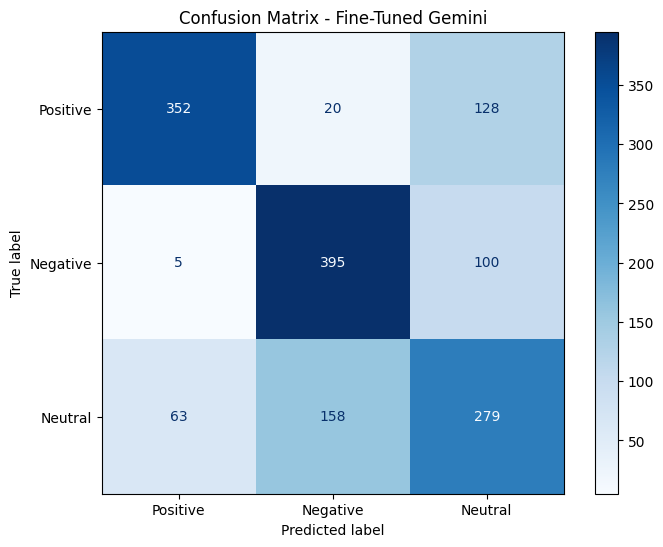

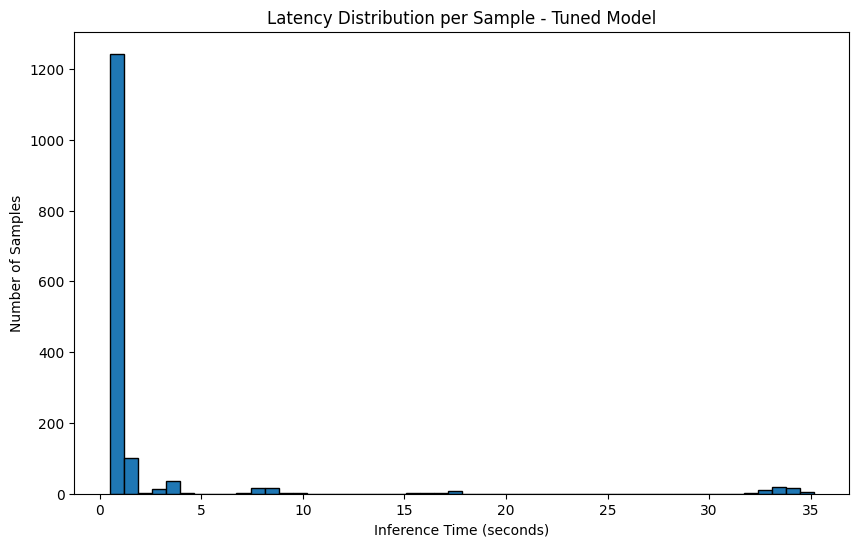


Benchmark complete.


In [ ]:
import numpy as np

# Runtime Metrics Calculation

avg_latency = np.mean(latencies) if latencies else 0
p95_latency = np.percentile(latencies, 95) if latencies else 0
p99_latency = np.percentile(latencies, 99) if latencies else 0
throughput = len(texts) / total_time if total_time > 0 else 0
memory_used = mem_after - mem_before


# Benchmark Results Presentation
print("\n" + "=" * 60)
print("Benchmark Results: Fine-Tuned Model".center(60))
print("=" * 60)
print("\n" + "Classification Metrics".center(60))
print("-" * 60)
print(f"Accuracy:             {accuracy:.4f}")
print(f"Precision (Macro):    {macro_precision:.4f}")  # Using Macro as requested
print(f"Recall (Macro):       {macro_recall:.4f}")  # Using Macro as requested
print(f"F1-Score (Macro):     {macro_f1:.4f}")  # Using Macro as requested
print("\nPer-Class Metrics:")
print(class_report)

print("\n" + "=" * 60)
print("Runtime Performance".center(60))
print("-" * 60)
print(f"Total Samples Processed: {len(texts)}")
print(f"Total Inference Time:    {total_time:.2f} seconds")
print(f"Average Latency:         {avg_latency:.4f} sec/sample")
print(f"95th Percentile Latency: {p95_latency:.4f} sec")
print(f"99th Percentile Latency: {p99_latency:.4f} sec")
print(f"Throughput:              {throughput:.2f} samples/sec")
print(f"Memory Usage Change:     {memory_used:.2f} MB")
print("=" * 60)


# Visual Confirmation
print("\nGenerating plots...")
try:
    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EXPECTED_LABELS)
    # Use ax=plt.gca() to plot on the current figure's axes
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix - Fine-Tuned Gemini")
    plt.savefig("tuned_confusion_matrix.png", bbox_inches="tight")
    plt.show()

    # Latency Distribution Plot
    if latencies:
        plt.figure(figsize=(10, 6))
        plt.hist(latencies, bins=50, edgecolor="black")
        plt.title("Latency Distribution per Sample - Tuned Model")
        plt.xlabel("Inference Time (seconds)")
        plt.ylabel("Number of Samples")
        plt.savefig("tuned_latency_distribution.png", bbox_inches="tight")
        plt.show()
    else:
        print("No latency data gathered to plot distribution.")

except Exception as plot_e:
    print(f"\nCould not display/save plots: {plot_e}")

print("\nBenchmark complete.")